## HW 5
### Gurhar Khalsa
#### Problem description:
* The dataset consists of 220,025 rgb images falling into two classes
* The goal is to successfully classify them as having cancer or not.
* I will resize the images to 96 x 96 x 3 tensor inputs due to memory constraints
* This notebook was developed on the Kaggle GPU servers


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf



print(os.listdir("../input/histopathologic-cancer-detection"))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
train_dir = "../input/histopathologic-cancer-detection/train/"
test_dir = "../input/histopathologic-cancer-detection/test"

df_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
df_train['id'] = df_train['id'].apply(lambda x:f'{x}.tif')
df_train.head()

df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


### Exploratory Data Analysis
* Checking the class distributions

In [5]:
# checking the class distribution
df_train.label.value_counts()


0    130908
1     89117
Name: label, dtype: int64

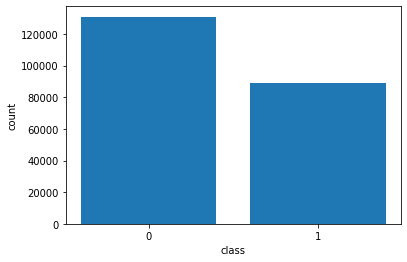

In [6]:
plt.xticks(df_train.label.unique(), df_train.label.unique())
plt.xlabel("class")
plt.ylabel("count")
plt.bar(df_train.label.unique(), [ df_train.label.value_counts()[0], df_train.label.value_counts()[1]]);

#### Data is not overly imbalanced

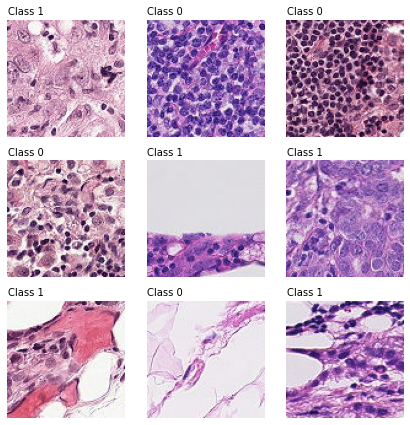

In [7]:
# examining some images

sample = df_train.sample(n=9).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i, row in sample.iterrows():  
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{row.id}')
    label = row.label
    
    plt.subplot(3,3,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### A few conclusions from EDA:
* These images are pretty different from imagnet images.
* Given the large size of the dataset, and how different the images are from imagenet, it should be appropriate to apply transfer learning with a pretrained network
* There is not a major class imbalance issue that would require resampling/undersampling/oversampling etc.
### Now time to split data into a training and validation set

In [10]:
df = df_train # using full dataset
#df = df_train.sample(frac=.3) # faster prototyping with random small sample
train, valid = train_test_split(df,test_size=0.2)

In [11]:
train['label'] = train['label'].apply(lambda x: str(x))
train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,label
105941,7d54b9864e1f48d12fade21e045535bfd931c018.tif,0
19870,f83e65dbee157275458e3d8c4f6c4cf9aad92eee.tif,1
219365,e6e998294ea8f5c2a6bb108f0116b7a857aaeb60.tif,0
61335,d9eeae12ce2ca674b4bb4fbb26b8dd092b0dd993.tif,0
74095,cad36947e078b9165c61ac23228abe8d7b1c4584.tif,0


In [12]:
valid['label'] = valid['label'].apply(lambda x: str(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
IMG_DIM = 96

* Now that I have split the data into a training and validation set, it is time to define a data loader
* The training data generator applies a list of image augmentations to make the training data more robust.
* I will be using a batch size of 64 and will be changing the images to be 96x96 pixels. This was as big as I could get them without getting memory errors. Larger images resulted in better training


In [14]:


BATCH_SIZE = 64
train_datagen = ImageDataGenerator(rescale=1/255, #normalizing input
#                                   
                             
                                  vertical_flip = True,
                                  horizontal_flip = True,
                                  rotation_range=90,
                                  zoom_range=0.2, 
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.05,
                                  channel_shift_range=0.1
                                  )

valid_datagen = ImageDataGenerator(rescale=1/255)

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (IMG_DIM,IMG_DIM)
)

valid_loader = valid_datagen.flow_from_dataframe(
    dataframe = valid,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (IMG_DIM,IMG_DIM)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Defining the model
* The top of the model will be a pretrained efficientnetb7 model. This model is like a resnet but supposed to be more efficient to train. 
* Using this model rather than an untrained convolutional network improved performance
* I have defined input shape as IMG_DIM (96) x IMG_DIM x 3. This is the input dimensions to the model. The images are 96 by 96 pixels with the additional dimension stemming from the fact that the images are rgb.
* After the pretrained layers the model is flattened into a regular MLP, with relu activation dropout and batchnormalization since these things help with overfitting
* I use two outputs with a softmax function to classify the two classes at the end.

In [15]:

from tensorflow.keras.layers import *
IN_SHAPE = input_shape=(IMG_DIM,IMG_DIM, 3)


conv_layers = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=IN_SHAPE,

)

model =  Sequential([

    conv_layers,

    Flatten(),
    
    Dense(IMG_DIM, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2, activation='softmax')
])




2021-11-30 17:48:23.133261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 17:48:23.271799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 17:48:23.272880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 17:48:23.274516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

258088960/258076736 [==============================] - 4s 0us/step


### Now to define some hyperparameters and training configurations
* I used Adam as an optimizer. I noticed that it worked a little better than SGD
* I also used a learning rate scheduling function that decreases the learning rate by a factor of 5 at each epoch after the second epoch, this helped slow down the gradient descent process as the model came closer to converging.
* I also used an early stopping callback that stopped training after two rounds of poor validation loss and restored the best model weights
* The hyperparamters and callbacks were ultimately selected based on trail and error

In [20]:
from keras.callbacks import EarlyStopping


optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001)

def schedule(epoch, lr):
#     if epoch > 2:
#         return lr*0.1
#     elif epoch > 3:
#         return lr*0.03
    
    return lr/5
   

model.compile(optimizer, loss = "binary_crossentropy", metrics=["accuracy", 
                                                                tf.keras.metrics.AUC()
                                                               ])

In [21]:
history = model.fit(x=train_loader, validation_data=valid_loader, epochs=10, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True),
                              tf.keras.callbacks.LearningRateScheduler(schedule)]
                   )

2021-11-30 17:48:42.556037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-30 17:49:19.457917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2751/2751 [==============================] - 2318s 827ms/step - loss: 0.2496 - accuracy: 0.9010 - auc: 0.9593 - val_loss: 2.4410 - val_accuracy: 0.6016 - val_auc: 0.6031
Epoch 2/10
2751/2751 [==============================] - 1673s 608ms/step - loss: 0.1509 - accuracy: 0.9454 - auc: 0.9811 - val_loss: 0.8550 - val_accuracy: 0.7703 - val_auc: 0.8028
Epoch 3/10
2751/2751 [==============================] - 1670s 607ms/step - loss: 0.1305 - accuracy: 0.9530 - auc: 0.9846 - val_loss: 0.4578 - val_accuracy: 0.8610 - val_auc: 0.9025
Epoch 4/10
2751/2751 [==============================] - 1660s 603ms/step - loss: 0.1276 - accuracy: 0.9542 - auc: 0.9850 - val_loss: 0.1217 - val_accuracy: 0.9566 - val_auc: 0.9852
Epoch 5/10
2751/2751 [==============================] - 1660s 603ms/step - loss: 0.1255 - accuracy: 0.9546 - auc: 0.9854 - val_loss: 0.1231 - val_accuracy: 0.9556 - val_auc: 0.9840
Epoch 6/10
2751/2751 [==============================] - 1661s 603ms/step - loss: 0.1249 - accuracy: 0.9552

### Plots training and validation error and accuracy

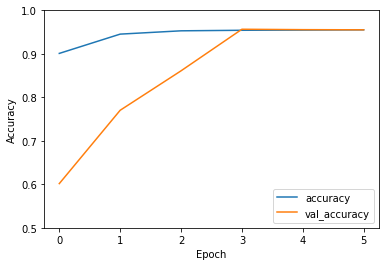

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

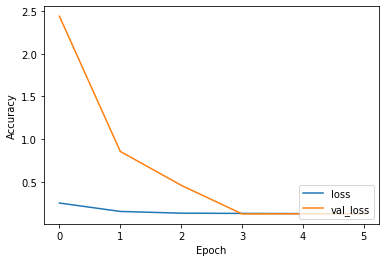

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Conclusions:
* The above plots suggest neither over nor under fitting. 
* Ultimately it was trial and error combined with observing some techniques that worked well for others. 
* I think if there were less memory constraints, I could have trained on larger images and maybe gotten better performance. 
* The experimentation with hyperparameters and callbacks ultimately good results with respect to the comparison of training and validation loss and accuracy.
* This model did not generalize perfectly to the test data however and got around .87 on the public leaderboard and .83 on the private leaderboard. However, my baseline models got around .7 so I am pleased with the improvement
### Predictions on test set

In [24]:
test_files = os.listdir("../input/histopathologic-cancer-detection/test")

In [25]:
df_test = pd.DataFrame({'id': test_files})

df_test.head()


,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [26]:
BATCH_SIZE = 64
TEST_PATH = "../input/histopathologic-cancer-detection/test"


test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = TEST_PATH,
    x_col = 'id',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (IMG_DIM,IMG_DIM)
)


Found 57458 validated image filenames.


In [27]:
probs = model.predict(test_loader)
probs

array([[8.91966403e-01, 1.08033553e-01],
       [9.99978900e-01, 2.10901853e-05],
       [9.96378243e-01, 3.62178893e-03],
       ...,
       [5.19080423e-02, 9.48091984e-01],
       [9.99999523e-01, 4.29886455e-07],
       [9.99899626e-01, 1.00360434e-04]], dtype=float32)

In [28]:
preds = [np.argmax(x) for x in probs]
# preds

In [29]:
df_test['label'] = preds
df_test['id'] = df_test['id'].apply(lambda x: x.replace(".tif", ""))
df_test.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [30]:
df_test.to_csv("submission.csv", index=False)

### Citations:
* Big thanks to FADHLI and LEOPOLD TCHOMGWI Their notebooks https://www.kaggle.com/fadhli/starter-code-keras-resnet50-0-9275-lb/notebook, and https://www.kaggle.com/leopoldtchomgwi/lt-cancer-detection-v02 helped with how to load the data, and plot image matrix
* image augmentation reference: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
* took some queues on the augmentation from this notebook as well: https://www.kaggle.com/jtmurkz/keras-resnet50-0-96lb